In [36]:
import pandas as pd
from phandas import *
import numpy as np

In [37]:
df = pd.read_parquet(r'C:\Users\USER\Documents\coinmarketdata\cmc_data_cleaned.parquet')
# Step 1: Reset index  
df_reset = df.reset_index()  
  
# Step 3: Combine name + symbol into a single identifier  
# Clean whitespace first to avoid issues like " "_UNKOWN  
df_reset['name'] = df_reset['name'].str.strip()  
df_reset['symbol'] = df_reset['symbol'].str.strip()  
  
# Combine name and symbol  
df_reset['symbol'] = df_reset['name'] + '_' + df_reset['symbol']  
  
    
# Drop the name column  
df_clean = df_reset.drop(columns=['name'])  

# Check for duplicates  
duplicates = df_clean.duplicated(subset=['timestamp', 'symbol'], keep=False)  
if duplicates.any():  
    print(f"Found {duplicates.sum()} duplicate rows")  
    print(df_clean[duplicates].head())  
      
# Remove duplicates - keep first occurrence  
df_clean = df_clean.drop_duplicates(subset=['timestamp', 'symbol'], keep='first') 
# Step 3: Set index to (timestamp, symbol)  
panel = df_clean.set_index(['timestamp', 'symbol'])  

  
# Verify you have multiple symbols  
print(f"Number of symbols: {len(panel.index.get_level_values('symbol').unique())}")  
print(f"Symbols: {panel.index.get_level_values('symbol').unique()}")  



Found 52768 duplicate rows
                timestamp             symbol  ...  market_cap_30d  volume_30d
14148 2022-01-06 23:59:59  Shadow Token_SHDW  ...             NaN         NaN
14149 2022-01-06 23:59:59  Shadow Token_SHDW  ...             NaN         NaN
16622 2022-01-07 23:59:59  Shadow Token_SHDW  ...             NaN         NaN
16623 2022-01-07 23:59:59  Shadow Token_SHDW  ...             NaN         NaN
19103 2022-01-08 23:59:59  Shadow Token_SHDW  ...             NaN         NaN

[5 rows x 11 columns]
Number of symbols: 9338
Symbols: Index(['0x Protocol_ZRX', '1inch Network_1INCH', '2GIVE_2GIVE', '42-coin_42',
       '4ART Coin_4ART', '88mph_MPH', '8PAY_8PAY', '99Starz_STZ', 'A2DAO_ATD',
       'AB_AB',
       ...
       'Furo_FURO', 'Light_LIGHT', 'OnePiece_1PIECE', 'PublicAI_PUBLIC',
       'RECON_RECON', 'TCOM Global_TCOM', 'BoatKid_BOATKID',
       'EtherFloki_EFLOKI', 'GPTON_GPTON', 'HODL Coin_HODL'],
      dtype='object', name='symbol', length=9338)


In [38]:

  
# Verify you have multiple symbols  
print(f"Number of symbols: {len(panel.index.get_level_values('symbol').unique())}")  
print(f"Symbols: {panel.index.get_level_values('symbol').unique()}")  
  
# Step 5: Convert columns to Factor objects  
# Extract close price  
close_df = panel[['close']].reset_index()  
close_df.columns = ['timestamp', 'symbol', 'factor']  
close_df['factor'] = pd.to_numeric(close_df['factor'], errors='coerce')  
close_df = close_df.dropna(subset=['factor'])  
close = Factor(close_df, 'close')  
  
# Extract volume  
volume_df = panel[['volume_30d']].reset_index()  
volume_df.columns = ['timestamp', 'symbol', 'factor']  
volume_df['factor'] = pd.to_numeric(volume_df['factor'], errors='coerce')  
volume_df = volume_df.dropna(subset=['factor'])  
volume = Factor(volume_df, 'volume')  

  
# Rank volume cross-sectionally (higher volume = higher rank)  
volume_rank = volume.rank()
# Extract open price  
open_df = panel[['open']].reset_index()  
open_df.columns = ['timestamp', 'symbol', 'factor']  
open_df['factor'] = pd.to_numeric(open_df['factor'], errors='coerce')  
open_df = open_df.dropna(subset=['factor'])  
open_price = Factor(open_df, 'open')  
  
# Step 6: Create momentum factor  
# 14-day momentum: (price_t-1 / price_t-15) - 1  
momentum_14 = (close.ts_delay(1) / close.ts_delay(15)) - 1 

# Keep only top 20% by volume (rank >= 0.8)  
top_volume_mask = volume_rank.data.copy()  
top_volume_mask['factor'] = (top_volume_mask['factor'] >= 0.8).astype(float) 

# Filter momentum to only include top volume assets  
filtered_momentum_data = momentum_14.data.merge(  
    top_volume_mask[['timestamp', 'symbol', 'factor']],   
    on=['timestamp', 'symbol'],  
    suffixes=('', '_mask')  
)  
  
# Keep only rows where mask is 1 (top volume)  
filtered_momentum_data = filtered_momentum_data[filtered_momentum_data['factor_mask'] > 0]  
filtered_momentum = Factor(  
    filtered_momentum_data[['timestamp', 'symbol', 'factor']],   
    'top_volume_momentum'  
)  


  



Number of symbols: 9338
Symbols: Index(['0x Protocol_ZRX', '1inch Network_1INCH', '2GIVE_2GIVE', '42-coin_42',
       '4ART Coin_4ART', '88mph_MPH', '8PAY_8PAY', '99Starz_STZ', 'A2DAO_ATD',
       'AB_AB',
       ...
       'Furo_FURO', 'Light_LIGHT', 'OnePiece_1PIECE', 'PublicAI_PUBLIC',
       'RECON_RECON', 'TCOM Global_TCOM', 'BoatKid_BOATKID',
       'EtherFloki_EFLOKI', 'GPTON_GPTON', 'HODL Coin_HODL'],
      dtype='object', name='symbol', length=9338)


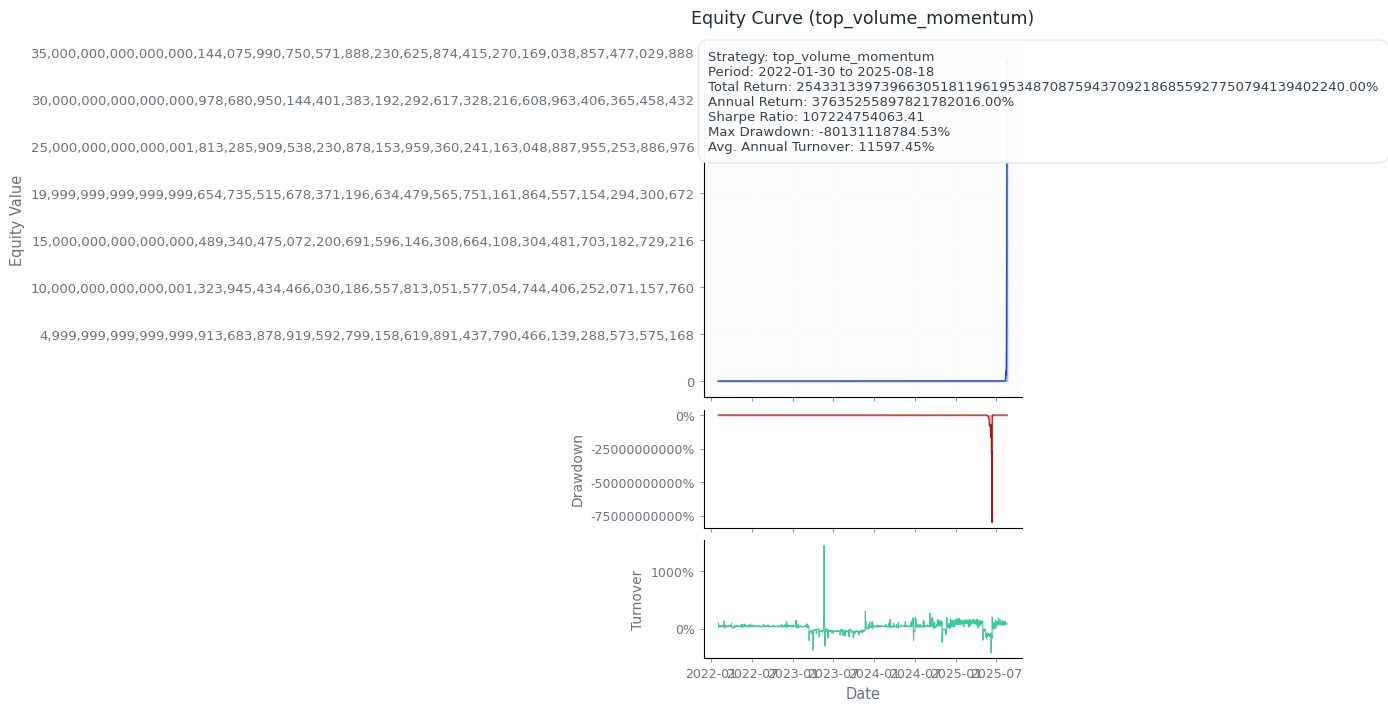

Backtester(strategy=top_volume_momentum, period=2022-01-30 to 2025-08-18, days=1297)

In [39]:
# Step 7: Backtest the strategy  
result = backtest(  
    price_factor=close,  
    strategy_factor=filtered_momentum,  
    transaction_cost=0.004,  
    initial_capital=100000  
)  
  
# Step 8: View results  
result.summary()  
result.plot_equity()